# The spelled-out intro to language modeling: building makemore

Following: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [1]:
from pathlib import Path
from collections import defaultdict

In [2]:
data = Path('../data')

# Exploring bigrams (0:00 - 0:15:00)

Tasks done in the video:
- Load the dataset
- Explore
    - min/max length of names
    - number of names
- count all the bigrams into a dictionary
    - dedicated \<S\> and \<E\> tokens

In [3]:
names = (data/'names.txt').open().read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(names)

32033

In [5]:
min(len(name) for name in names), max(len(name) for name in names)

(2, 15)

In [6]:
bigrams = defaultdict(int)
start = '<S>'
end = '<E>'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        bigrams[(ch1,ch2)] += 1

In [7]:
sorted((bigram_tuples for bigram_tuples in bigrams.items()), key=lambda b: b[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Bigrams into torch.Tensor ( - 00:36:00, skipping efficiency until 00:50:00)

- Goal: n*n matrix that holds the bigram count in each cell
- No more dedicated start/stopping tokens, instead use . for both
- sample from the model
    - start with the starting dot
    - choose random next character according to probabilities in that row (torch.multinomial)
    - repeat until ending-dot is reached
    - Use torch.Generator for comparability

### Bigrams to Tensor

Extracting all used characters:

In [8]:
characters = set('.')
characters = characters.union(set(''.join(names)))
characters

{'.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [9]:
import torch

In [10]:
stoi = {char: i for i,char in enumerate(characters)}
itos = {i: char for char,i in stoi.items()}
stoi

{'n': 0,
 '.': 1,
 'h': 2,
 'x': 3,
 'u': 4,
 'f': 5,
 'c': 6,
 's': 7,
 'k': 8,
 'g': 9,
 'd': 10,
 'r': 11,
 'i': 12,
 'e': 13,
 't': 14,
 'b': 15,
 'm': 16,
 'p': 17,
 'l': 18,
 'w': 19,
 'z': 20,
 'a': 21,
 'v': 22,
 'q': 23,
 'o': 24,
 'j': 25,
 'y': 26}

In [11]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        bigrams[row_index, col_index] += 1

### Sampling

Counts for characters following the start character:

In [12]:
bigrams[stoi[start],:]

tensor([1146.,    0.,  874.,  134.,   78.,  417., 1542., 2055., 2963.,  669.,
        1690., 1639.,  591., 1531., 1308., 1306., 2538.,  515., 1572.,  307.,
         929., 4410.,  376.,   92.,  394., 2422.,  535.])

Drawing a sample with counts as weights:

In [13]:
next_idx = torch.multinomial(bigrams[stoi[start],:], 1, replacement=True).item()
next_char = itos[next_idx]
next_char

'k'

Repeat until the stopping token is drawn:

In [14]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(bigrams[stoi[name[-1]],:], 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.lor.
.xow.
.ppteorvayisangahelika.
.dr.
.lbequmynarinth.
.ahlikrishachridatacosstrisolel.
.rghan.
.keryan.
.bre.
.mahaixxtahan.
.kh.
.h.
.eleeerh.
.jaaluirielaban.
.y.
.ko.
.aierstheayaholaikiemaie.
.jamah.
.ba.
.dawisilayvelonalari.


Sanity-Check: Drawing with uniform probability

In [15]:
g = torch.Generator().manual_seed(2147483647)
weights = torch.ones(len(characters))

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(weights, 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.pvw.
..
.johplpejpqaytgv.
.tarbzudvukunptbjezyuapr.
.zufzrmcdusgsvifdcrlwpiqtglskkyqianguxonxfreyaxdtdbfbvdvlsspldlnxchk.
.hrwimbrxnozoqhmertaawousycfokqpmiumutqyvrjowpdcblppmcowzqrcbackvqckewajjbzvxvvpmcxhjudxbakr.
.drkpttmpeeii.
.blupjnswymqnyisgdgt.
.tsyyaaiwjvplaca.
.q.
.vwuhtqvieljmvslwcsmwksteq.
.cpewduvhktsvbggsokrquizlurqt.
.syjrtpvnicwzupgsvtxubgufzwarsumnxcmdwofpdxwedqsayfwnqbcicdocijishfsmdumbvuzqnuiyjwpzlhkokxutfgaaenozjwiche.
.hb.
..
.tjdmbdaadcixw.
.axpxszdeiypzh.
.gwvolzsamrmmgsoaufduywlbpfgsbvaoevzndiocbirbyxgnzrkugvrugc.
.oxfvimrzrqqvaoijezqjismy.
.aquvocvhbbciuumkedfbedsdxpfpqznnqioxixdhenpaajgdztyejxwkxibledjlflpwibeulihaqptiegzhlepkzhuqhjviweqthblqxukdbzfyqtwoavccvgtlefufiahkucsz.


# Loss function ( - 01:03:00)

- negative Likelihood is used to measure loss (product of probabilities)
- use logs for numerical purposes (turns into the sum)

In [16]:
P = bigrams / bigrams.sum(dim=1, keepdim=True)

In [17]:
for name in names[:2]:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., e): -3.0408453941345215
(e, m): -3.2793259620666504
(m, m): -3.6772043704986572
(m, a): -0.9417552351951599
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 12.568990707397461
Mean Neg. Log-Likelihood: 2.513798236846924

(., o): -4.3981709480285645
(o, l): -2.550807476043701
(l, i): -1.7277942895889282
(i, v): -4.186665058135986
(v, i): -1.0382850170135498
(i, a): -1.9795759916305542
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 17.511159896850586
Mean Neg. Log-Likelihood: 2.501594305038452



In [18]:
for name in ['andrej']:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., a): -1.9828919172286987
(a, n): -1.8295611143112183
(n, d): -3.259352207183838
(d, r): -2.562042474746704
(r, e): -2.012739896774292
(e, j): -5.917083740234375
(j, .): -3.7097861766815186
Neg. Log-Likelihood: 21.273456573486328
Mean Neg. Log-Likelihood: 3.03906512260437



# Neural Network Approach ( - 01:25:00)

- create training set
    - x tensor with first letter
    - y tensor with second letter
- use one-hot encoding to feed indices into nn
- "nn" is for now just a weight matrix and bias vector with grads
- output should be 27 dimensional
    - turn into "probabilities" by softmax
    

In [19]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names[:1]:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [20]:
g = torch.Generator().manual_seed(2147483647)

W = torch.rand(size=(27,27), requires_grad=True, generator=g)
b = torch.rand(size=(1,27), requires_grad=True, generator=g)

In [21]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.]])

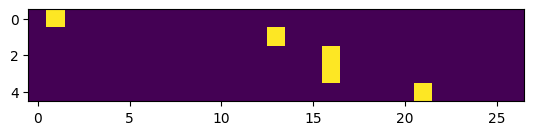

In [22]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [23]:
# xenc: 5 x 27
# W: 27 x 27
# xenc @ W: 5 x 27
# b: 1 x 27

output = xenc@W + b
output.shape

torch.Size([5, 27])

In [24]:
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

probs[0,:]

tensor([0.0294, 0.0495, 0.0214, 0.0271, 0.0405, 0.0393, 0.0264, 0.0334, 0.0254,
        0.0506, 0.0365, 0.0340, 0.0306, 0.0361, 0.0889, 0.0278, 0.0535, 0.0395,
        0.0170, 0.0223, 0.0242, 0.0284, 0.0777, 0.0431, 0.0434, 0.0168, 0.0371],
       grad_fn=<SliceBackward0>)

In [25]:
F.softmax(output, dim=1)[0,:]

tensor([0.0294, 0.0495, 0.0214, 0.0271, 0.0405, 0.0393, 0.0264, 0.0334, 0.0254,
        0.0506, 0.0365, 0.0340, 0.0306, 0.0361, 0.0889, 0.0278, 0.0535, 0.0395,
        0.0170, 0.0223, 0.0242, 0.0284, 0.0777, 0.0431, 0.0434, 0.0168, 0.0371],
       grad_fn=<SliceBackward0>)

# Training loop ( - 01:47:00)

- get loss by taking nn-prob of actual next character
    - should be high --> neg. --> should be low
    - .log().mean()
- backward pass (set gradients to None)
- learning rate of 50 for now
- run training loop over all xs for now

In [26]:
# nn evaluation

xenc = F.one_hot(xs, num_classes=27).float()

output = xenc@W + b
probs = F.softmax(output, dim=1)

# actual next characters for each x in xs is in ys
predictions = probs[torch.arange(len(ys)), ys]
loss = predictions.log().mean()
loss

tensor(-3.1338, grad_fn=<MeanBackward0>)

In [27]:
# build training set with all data
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [28]:
# initialize nn
n_epochs = 100
lr = 50

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    output = xenc@W
    probs = F.softmax(output, dim=1)

    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    print(loss.item())

3.3382649421691895
3.0802760124206543
2.9226419925689697
2.828274726867676
2.764129161834717
2.7179553508758545
2.6836931705474854
2.6574463844299316
2.6367342472076416
2.6199684143066406
2.606107473373413
2.5944442749023438
2.5844836235046387
2.5758697986602783
2.568338394165039
2.561690330505371
2.5557734966278076
2.550469398498535
2.5456840991973877
2.5413424968719482
2.537384033203125
2.5337586402893066
2.5304250717163086
2.5273492336273193
2.5245025157928467
2.5218586921691895
2.5193982124328613
2.517101526260376
2.514953851699829
2.5129404067993164
2.51104998588562
2.509270668029785
2.5075936317443848
2.5060102939605713
2.504513740539551
2.503096103668213
2.5017521381378174
2.5004758834838867
2.499262571334839
2.498108148574829
2.4970076084136963
2.495958089828491
2.494955539703369
2.49399733543396
2.4930806159973145
2.4922029972076416
2.491361379623413
2.490554094314575
2.489778995513916
2.4890341758728027
2.4883177280426025
2.4876291751861572
2.4869654178619385
2.48632597923278

# Notes ( - end)

- matrix multiply with one-hot encoded vector is the same as row-lookup (does indexing work with autograd?)
- fake-counts is the same as regularization
    -  + (W**2).mean()

In [29]:
# initialize nn
n_epochs = 100
lr = 50

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs,:]
    probs = F.softmax(output, dim=1)


    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    print(loss.item())

3.3382649421691895
3.080275535583496
2.922642469406128
2.8282742500305176
2.7641282081604004
2.7179553508758545
2.683692216873169
2.6574456691741943
2.6367340087890625
2.6199681758880615
2.606107234954834
2.5944442749023438
2.5844836235046387
2.5758700370788574
2.56833815574646
2.561690330505371
2.5557734966278076
2.550469398498535
2.5456840991973877
2.5413424968719482
2.537384033203125
2.5337588787078857
2.5304250717163086
2.5273494720458984
2.5245025157928467
2.5218586921691895
2.5193982124328613
2.517101764678955
2.51495361328125
2.5129404067993164
2.511049509048462
2.509270668029785
2.5075936317443848
2.5060107707977295
2.504513740539551
2.503096103668213
2.5017521381378174
2.500476121902466
2.499262809753418
2.49810791015625
2.4970076084136963
2.495957851409912
2.494955539703369
2.49399733543396
2.4930806159973145
2.4922029972076416
2.491361379623413
2.490554094314575
2.489778995513916
2.4890341758728027
2.4883179664611816
2.487628698348999
2.4869654178619385
2.486325979232788
2.4

In [34]:
# initialize nn
n_epochs = 100
lr = 50
l2 = .01

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs,:]
    probs = F.softmax(output, dim=1)


    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean() + l2 * (W**2).mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    with torch.no_grad():
        # loss without regularization term
        loss = -predictions.log().mean()
        print(loss.item())

3.3382649421691895
3.080183506011963
2.922731399536133
2.8285632133483887
2.7646055221557617
2.718595504760742
2.684464693069458
2.6583266258239746
2.6377055644989014
2.621018648147583
2.607226848602295
2.595625162124634
2.5857207775115967
2.577158212661743
2.569673776626587
2.563070297241211
2.5571959018707275
2.551931858062744
2.547184705734253
2.542879819869995
2.5389564037323
2.535365343093872
2.532064437866211
2.529020309448242
2.5262036323547363
2.5235893726348877
2.5211572647094727
2.518888235092163
2.516766309738159
2.5147786140441895
2.5129122734069824
2.5111570358276367
2.509503126144409
2.507941961288452
2.506466865539551
2.505070209503174
2.503746271133423
2.5024895668029785
2.501295328140259
2.5001585483551025
2.4990763664245605
2.4980435371398926
2.497058153152466
2.4961161613464355
2.49521541595459
2.4943530559539795
2.4935264587402344
2.49273419380188
2.491973400115967
2.4912424087524414
2.4905402660369873
2.4898645877838135
2.4892141819000244
2.4885873794555664
2.48798

# Exercises

## #1 Trigram model

In [105]:
# build training set
start = ['.']
end = ['.']

xs = []
ys = []

for name in names:
    name = 2*start + list(name) + end
    for ch1,ch2,ch3 in zip(name, name[1:], name[2:]):
        #print(f'({ch1}{ch2}: {ch3}')
        xs.append([stoi[ch1], 27+stoi[ch2]])
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [106]:
xs[:5], ys[:5]

(tensor([[ 1, 28],
         [ 1, 40],
         [13, 43],
         [16, 43],
         [16, 48]]),
 tensor([13, 16, 16, 21,  1]))

In [117]:
# initialize nn
n_epochs = 1000
lr = 100
l2 = .0

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(54,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs].sum(dim=1)
    probs = F.softmax(output, dim=1)

    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean() + l2 * (W**2).mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    if epoch%50==0:
        print(epoch, loss.item())

    if epoch%300==0:
        lr /= 10

0 3.3666110038757324
50 2.4660329818725586
100 2.416826009750366
150 2.395254135131836
200 2.382878065109253
250 2.3747732639312744
300 2.369027853012085
350 2.3684580326080322
400 2.367990493774414
450 2.3675355911254883
500 2.3670926094055176
550 2.366661787033081
600 2.3662424087524414
650 2.3661937713623047
700 2.366152286529541
750 2.3661112785339355
800 2.366070032119751
850 2.3660292625427246
900 2.3659884929656982
950 2.365983724594116


In [118]:
# sampling

for _ in range(10):
    name = '..'
    while True:
        ch1 = stoi[name[-2]]
        ch2 = stoi[name[-1]]

        logits = W[[ch1, ch2]].sum(dim=0)
        probs = F.softmax(logits, dim=0)

        next = torch.multinomial(probs, 1, replacement=True)
        next_char = itos[next.item()]
        name = name + next_char

        if next_char=='.':
            break

    print(name)

..aadyd.
..az.
..asmdzetpsiquri.
..uaiuxmers.
..eln.
..ae.
..aaaen.
..azqebarcoe.
..oe.
..aelesiely.
